<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-и-функции" data-toc-modified-id="Импорт-и-функции-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт и функции</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подбор-параметров-с-Optuna" data-toc-modified-id="Подбор-параметров-с-Optuna-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Подбор параметров с Optuna</a></span><ul class="toc-item"><li><span><a href="#XGB" data-toc-modified-id="XGB-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>XGB</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>LinearRegression</a></span></li></ul></li><li><span><a href="#Кросс-валидация" data-toc-modified-id="Кросс-валидация-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Кросс-валидация</a></span><ul class="toc-item"><li><span><a href="#XGB" data-toc-modified-id="XGB-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>XGB</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>LinearRegression</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Импорт и функции

In [2]:
!pip install optuna

     |████████████████████████████████| 390 kB 1.7 MB/s eta 0:00:01


In [3]:
#import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    cross_val_score,
    cross_validate
)
from sklearn.metrics import (
    mean_squared_error,
    make_scorer
)
from statsmodels.tsa.seasonal import seasonal_decompose
#ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import optuna
import joblib
from sklearn.inspection import permutation_importance

In [4]:
#стиль
plt.style.use("tableau-colorblind10")
color_pal = sns.color_palette('Set2')

In [5]:
#рисование временного ряда
def time_series(df, color, title , size = (12,6), style = '-', ax = None):
  df.plot(
      figsize = size,
      grid = True,
      style = style,
      ax = ax,
      fontsize = 12,
      color = color,
  )
  plt.title(title + '\n', fontsize = size[0])
  plt.xlabel('Дата', fontsize = size[0]);

In [6]:
#временной ряд со скользящим средним
def time_series_rolling(df, size, title, rolling, ax = None):
  df = df.copy()
  df['rolling'] = df['num_orders'].rolling(rolling).mean()
  df.plot(
      figsize = size,
      grid = True,
      ax = ax,
      fontsize = size[0]/2,
  )
  plt.title(title, fontsize = size[0])
  plt.xlabel('Дата', fontsize = size[0]);

In [7]:
#создание признаков
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    for rol in range(1, rolling_mean_size + 1):
        df['rolling_mean'] = df['num_orders'].shift().rolling(rol).mean()
    df.dropna(inplace = True)
    return df

In [8]:
#model evaluation for time series with timeseriessplit
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring = "neg_root_mean_squared_error",
    )
    cv_results['test_score'] = cv_results['test_score']*(-1)
    rmse = cv_results["test_score"]
    print(f'RMSE of {model} is : {rmse.mean():.3f}')
    return cv_results

## Подготовка

In [9]:
#read csv
taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0],  index_col = 'datetime')
#сортируем индексы по возрастанию
taxi.sort_index(inplace = True)

In [10]:
#check dataframe
display(taxi.head())
display(taxi.isna().sum())
taxi.describe()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


num_orders    0
dtype: int64

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Пропусков нет, получены основные характеристики наших данных

In [11]:
#проверка последовательности индексов
if taxi.index.is_monotonic_increasing == True:
    print('Временной ряд отсортирован, индексы следуют в хронологическом порядке')

Временной ряд отсортирован, индексы следуют в хронологическом порядке


In [12]:
#analysis
display(taxi.dtypes)
print(f"Индексы имеют тип DateTime :{type(taxi.index)}")

num_orders    int64
dtype: object

Индексы имеют тип DateTime :<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


## Анализ

Построим график исходных данных

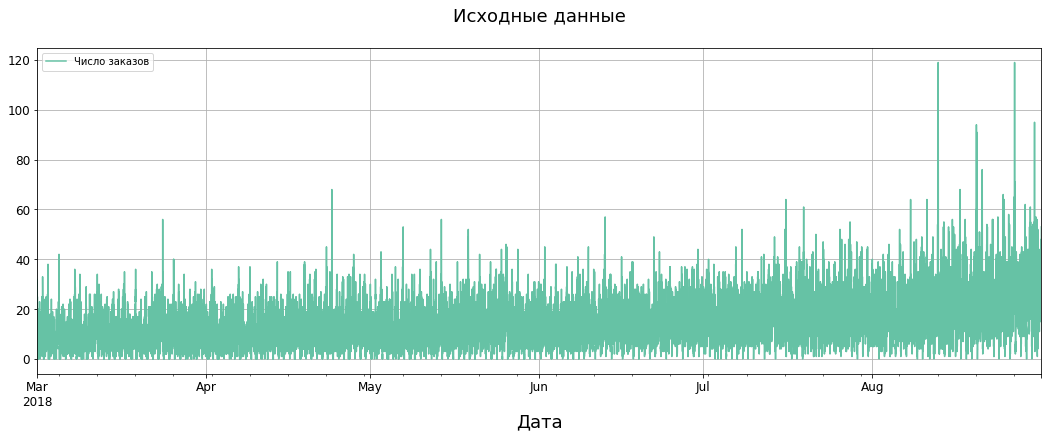

In [13]:
#график исходных данных
time_series(taxi, color_pal[0], 'Исходные данные', (18,6))
plt.legend(['Число заказов']);

Ресэмплируем данные согласно заданию

In [14]:
#ресэмплируем данные с интервалом в 1 час и суммируем их за день
data_res = taxi.resample('1H').sum()

In [17]:
type(data_res)

pandas.core.frame.DataFrame

Смотрим на вновь полученный ряд

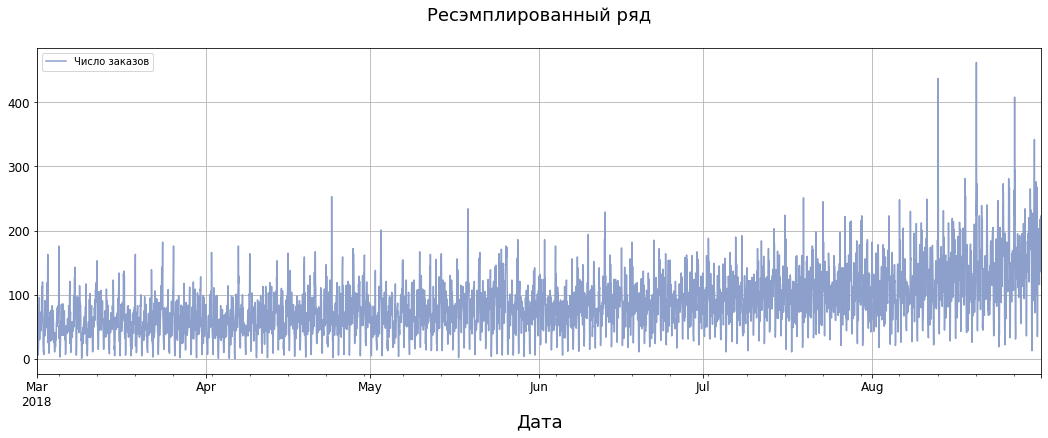

In [14]:
#ресэмплированный ряд
time_series(data_res, color_pal[2], 'Ресэмплированный ряд', (18,6))
plt.legend(['Число заказов']);

Взглянем на распределение значений данных после ресэмплирования

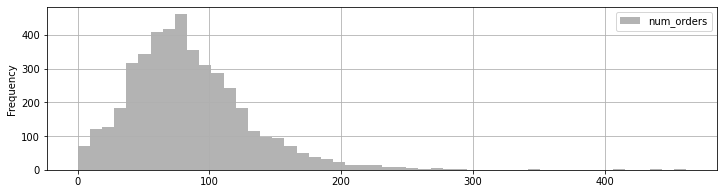

In [15]:
#гистограмма распределения числа поездок
data_res.plot.hist(
    figsize = (12,3),
    bins = 50,
    grid = True,
    color = color_pal[7]
)
plt.legend(['Кол-во заказов']);

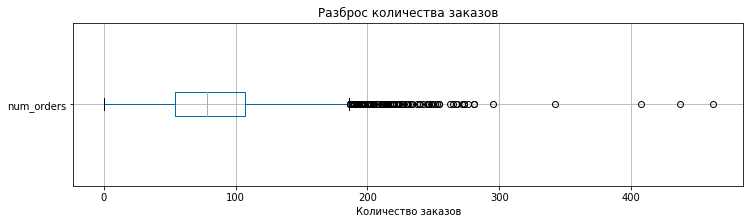

In [16]:
#ящик с усами
data_res.boxplot(
    figsize = (12,3),
    vert = False
)
plt.title('Разброс количества заказов')
plt.xlabel('Количество заказов');

In [17]:
#describe
data_res.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Распределение скошено вправо, присутствует много дней с заказами около 200 и более. 
В целом я считаю, что небольшой срез пиков в районе 250 должен немного повысить качество предсказаний, однако целиком грубо фильтровать не стоит

Построим график со скользящим средним с окном в неделю

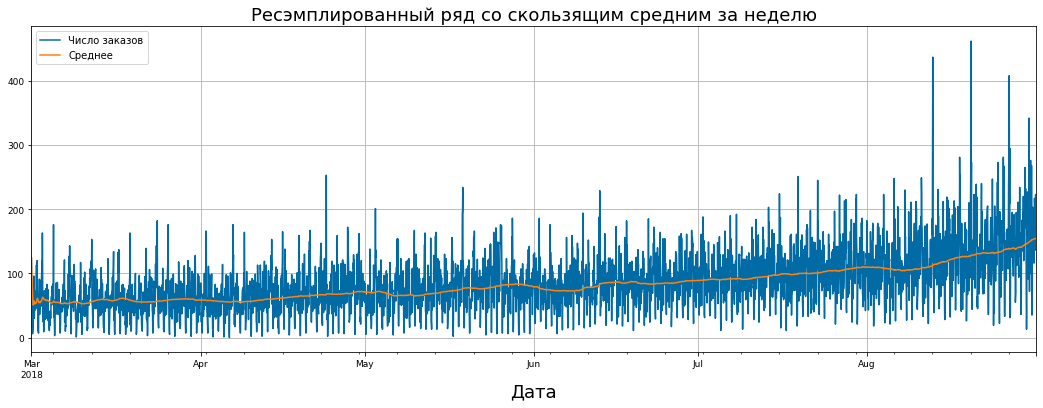

In [18]:
#with rolling mean
time_series_rolling(data_res,(18,6), 'Ресэмплированный ряд со скользящим средним за неделю', ('7d') )
plt.legend(['Число заказов', 'Среднее']);

Очевидно, число заказов плавно растет с марта по август, пики приходятся на конец лета. Посмотрим на данные по сезонам отдельно

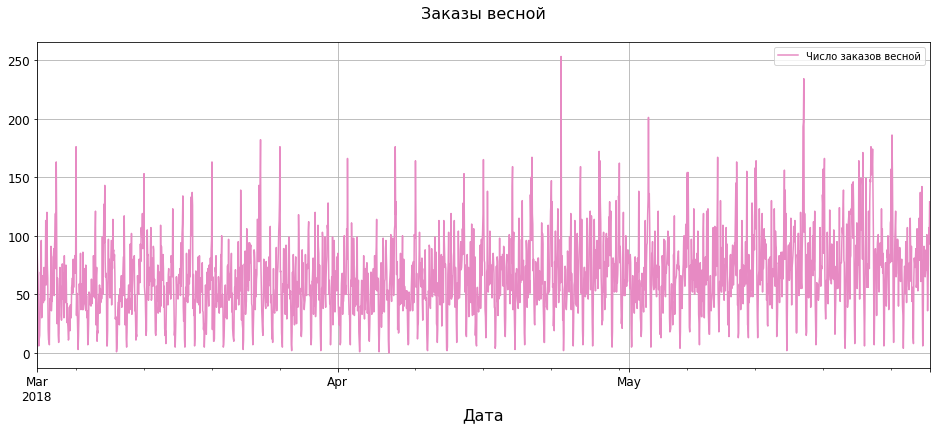

In [19]:
#график в весенний период по ресэпмлированным данным
time_series(data_res['2018-03':'2018-05'], color_pal[3],'Заказы весной', (16,6))
plt.legend(['Число заказов весной']);

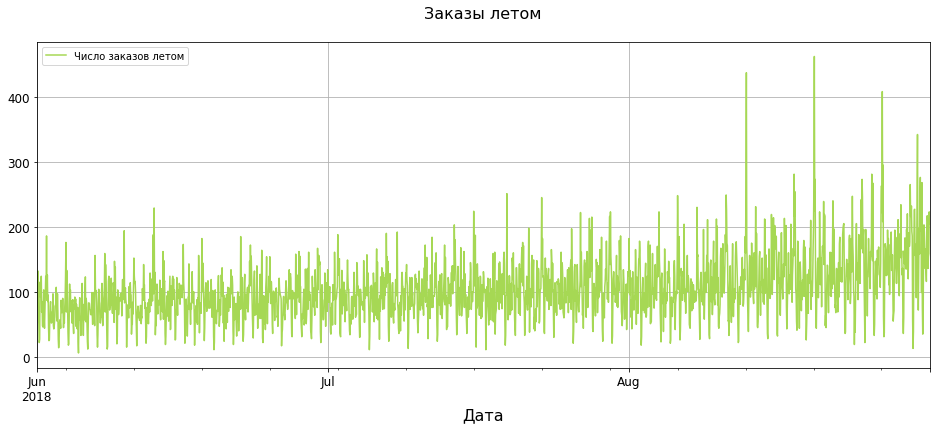

In [20]:
#график в летний период по ресэпмлированным данным
time_series(data_res['2018-06':'2018-08'], color_pal[4], 'Заказы летом',(16,6))
plt.legend(['Число заказов летом']);

Разложим ряд на составляющие

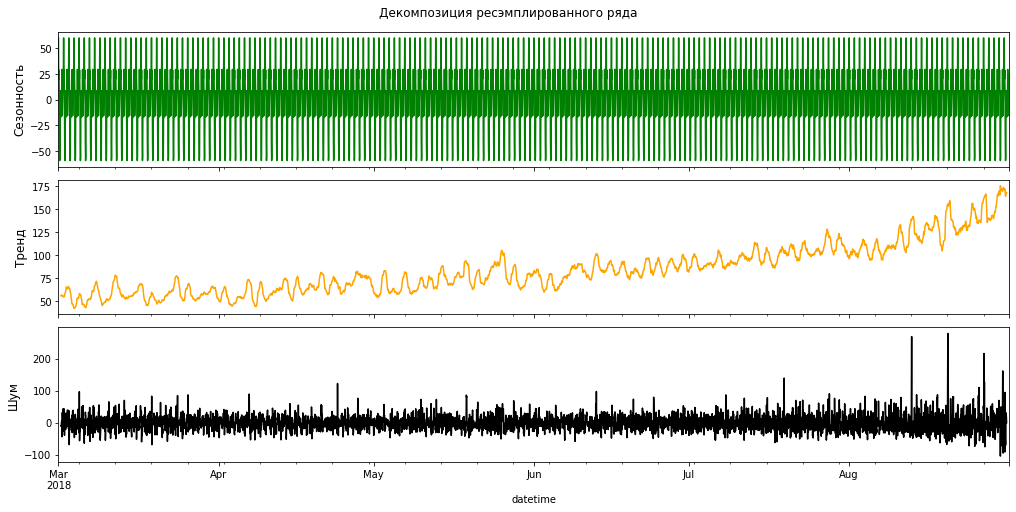

In [21]:
#декомпозиция ряда
decompose = seasonal_decompose(data_res)

#make some color magic
fig, axes = plt.subplots(3, 1, figsize=(14,7), constrained_layout = True)
fig.suptitle('Декомпозиция ресэмплированного ряда')
#seasonal
decompose.seasonal.plot(ax = axes [0], color = 'green')
axes[0].set_ylabel('Сезонность', fontsize = 12)
#trend
decompose.trend.plot(ax = axes [1], color = 'orange', sharex = axes[0])
axes[1].set_xlabel('Дата', fontsize = 12)
axes[1].set_ylabel('Тренд', fontsize = 12);
#noise
decompose.resid.plot(ax = axes [2], color = 'black')
axes[2].set_ylabel('Шум', fontsize = 12);

В графике, отражающем сезонность ряда, практически ничего не видно. Посмотрим на него в срезе за день, неделю и месяц.  
Движение же тренда понятно, заказы плавно растут и достигают наибольших значений в конце лета

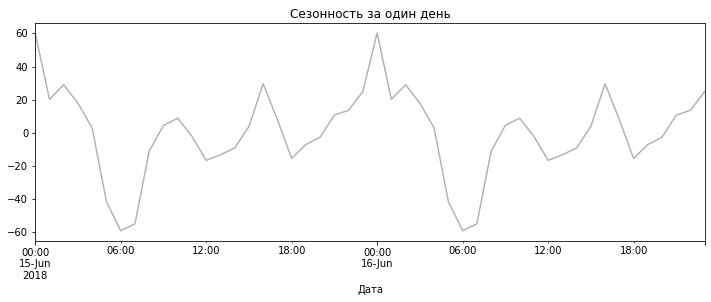

In [22]:
#сезонность поездок за один день
decompose.seasonal['2018-06-15':'2018-06-16'].plot(color = color_pal[7], figsize = (12,4))
plt.title('Сезонность за один день', fontsize = 12);
plt.xlabel('Дата');

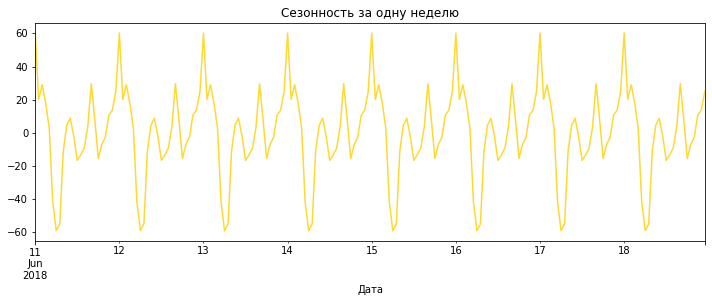

In [23]:
#сезонность поездок за одну неделю
decompose.seasonal['2018-06-11':'2018-06-18'].plot(color = color_pal[5], figsize = (12,4))
plt.title('Сезонность за одну неделю', fontsize = 12);
plt.xlabel('Дата');

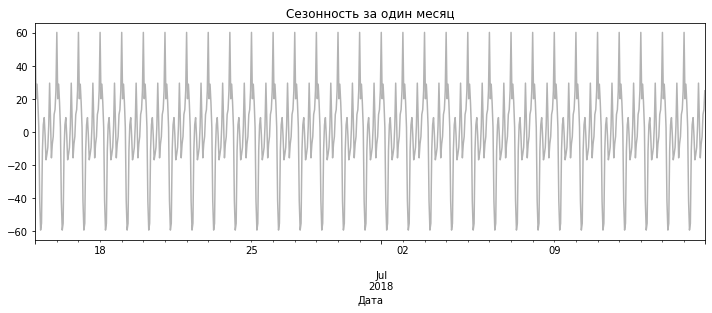

In [24]:
#сезонность поездок за один день
decompose.seasonal['2018-06-15':'2018-07-15'].plot(color = color_pal[7], figsize = (12,4))
plt.title('Сезонность за один месяц', fontsize = 12);
plt.xlabel('Дата');

Из графиков можем увидеть, что в целом заказов ранним утром обычно меньше, чем в течение дня и под вечер, основный пик приходися на околоночное время

###  Вывод

- провели ресэмплирование в интервале одного часа согласно задания
- проанализровали распределение заказов, построили гистограмму и ящик с усами
- разложили временной ряд на составляющие тренда и сезонности
- определилил границу фильтра для повышения качества предсказаний модели

## Обучение

Размер окна примем равным 72 часам, число лагов возьмем равным интервалу суточного сезона, т.е. 24 часа 

In [26]:
#make features
df = make_features(data_res, 24, 72)
#разбиение на выборки
train, test = train_test_split(df, test_size = .1, shuffle = False )
#check splitting
print(f'Размер Train: {train.shape[0]} и размер Test: {test.shape[0]}')
#признаки для обучающей и тестовой выборок
X_train = train.drop('num_orders', axis=1)
X_test = test.drop('num_orders', axis=1)
y_train = train['num_orders']
y_test = test['num_orders']
#check train and test
X_train.shape[0], X_test.shape[0]

Размер Train: 3909 и размер Test: 435


(3909, 435)

Для подбора параметров вручную создадим из тренировочной выборки валидационную, запретив перемешивание для предотвращения утечки(захват данных из будущего)

In [27]:
#создадим валидационную выборку вручную для Optuna
train_small, val = train_test_split(train, test_size = .3, shuffle = False)
print(f'Размер обучающей подвыборки: {train_small.shape[0]} и размер валидационной подвыборки: {val.shape[0]}')
print(f'Размер исходной: {train.shape[0]}')
#признаки
X_small = train_small.drop('num_orders', axis=1)
X_val = val.drop('num_orders', axis=1)
y_small = train_small['num_orders']
y_val = val['num_orders']

Размер обучающей подвыборки: 2736 и размер валидационной подвыборки: 1173
Размер исходной: 3909


### Подбор параметров с Optuna

#### XGB

In [45]:
#XGBRegressor
def objective(trial):
  #сделаем функцию rmse
    params = {
        "learning_rate" : trial.suggest_float('learning_rate', 1e-4, .5, log = True),
        'colsample_bytree' : trial.suggest_float('colsample_bytree',1e-4, 1.0, log = True),
        "colsample_bynode" : trial.suggest_float('colsample_bynode', 1e-4, 1.0, log = True),
        "max_depth" : trial.suggest_int('max_depth', 2, 5),
        "n_estimators" : trial.suggest_int('n_estimators', 200, 1000),
        "subsample" : trial.suggest_float('subsample', 1e-4, 1, log = True),
        #"reg_alpha" : trial.suggest_float('reg_alpha', 1e-4, 1, log = True),
        #"reg_lambda" : trial.suggest_float('reg_lambda', 1e-4, 1, log = True)
        }

    model = XGBRegressor(n_jobs = -1,
                         random_state = 21, **params)
    model.fit(X_small,y_small,verbose = True)
    preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, preds,squared=False)
    return rmse
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 20)

[I 2023-07-11 08:42:15,306] A new study created in memory with name: no-name-f1a6a5a7-f3bc-4ad4-892f-6ef19248449c
[I 2023-07-11 08:42:50,479] Trial 0 finished with value: 37.425135625564344 and parameters: {'learning_rate': 0.008890753011804281, 'colsample_bytree': 0.37334707386980864, 'colsample_bynode': 0.00029451198107988656, 'max_depth': 3, 'n_estimators': 717, 'subsample': 0.037255212462055924}. Best is trial 0 with value: 37.425135625564344.
[I 2023-07-11 08:43:20,986] Trial 1 finished with value: 38.84263511465214 and parameters: {'learning_rate': 0.029272515731725603, 'colsample_bytree': 0.017464633561355608, 'colsample_bynode': 0.18634936457402906, 'max_depth': 3, 'n_estimators': 735, 'subsample': 0.001973882174595457}. Best is trial 0 with value: 37.425135625564344.
[I 2023-07-11 08:43:27,068] Trial 2 finished with value: 104.59175679803568 and parameters: {'learning_rate': 0.0002944072692877511, 'colsample_bytree': 0.05106646919880078, 'colsample_bynode': 0.14876829027052563

In [49]:
#XGB best params from optuna
xgb_params = study.best_params
xgb_params

{'learning_rate': 0.10308439765953002,
 'colsample_bytree': 0.9732237914777332,
 'colsample_bynode': 0.0001281669141543118,
 'max_depth': 4,
 'n_estimators': 378,
 'subsample': 0.9430686076987445}

In [50]:
#XGB best RMSE Value on valid set
xgb_optuna_score = study.best_value
xgb_optuna_score

33.53478953520122

In [51]:
#сохраним модель с подобранными параметрами
xgb = XGBRegressor(random_state = 21,
                   **xgb_params)
# save model v2
joblib.dump(xgb, 'time_series_11/xgb.pkl');

####  RandomForestRegressor

In [52]:
#RandomForest
def objective(trial):
  #сделаем функцию rmse
    rmse_score = make_scorer(mean_squared_error,
                   squared = False,
                   greater_is_better = False)
    params = {
        'max_features':trial.suggest_categorical('max_features',["sqrt", 'log2']),
        "min_samples_leaf" : trial.suggest_int('min_samples_leaf',1,10),
        "max_depth" : trial.suggest_int('max_depth', 2, 5),
        "n_estimators" : trial.suggest_int('n_estimators', 200, 1000),
        "min_samples_split" : trial.suggest_float('min_samples_split', 0.01,1.0, log = True)
        }

    model = RandomForestRegressor(n_jobs = -1,
                                  random_state = 21, **params)

    model.fit(X_small,y_small)
    preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, preds,squared=False)
    return rmse
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective, n_trials = 20)

[I 2023-07-11 08:47:39,404] A new study created in memory with name: no-name-b77b0ac5-524f-45c5-959c-90cf4bbb0d27
[I 2023-07-11 08:47:40,801] Trial 0 finished with value: 46.60046996473626 and parameters: {'max_features': 'sqrt', 'min_samples_leaf': 5, 'max_depth': 2, 'n_estimators': 904, 'min_samples_split': 0.5158405061975072}. Best is trial 0 with value: 46.60046996473626.
[I 2023-07-11 08:47:42,532] Trial 1 finished with value: 43.355440895096685 and parameters: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'max_depth': 4, 'n_estimators': 904, 'min_samples_split': 0.31531281898898617}. Best is trial 1 with value: 43.355440895096685.
[I 2023-07-11 08:47:43,756] Trial 2 finished with value: 45.23266784388691 and parameters: {'max_features': 'log2', 'min_samples_leaf': 5, 'max_depth': 2, 'n_estimators': 723, 'min_samples_split': 0.011938581411816954}. Best is trial 1 with value: 43.355440895096685.
[I 2023-07-11 08:47:45,580] Trial 3 finished with value: 45.51416647576724 and parame

In [56]:
#RandomForest best params from optuna
rf_params = study_rf.best_params
rf_params

{'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'max_depth': 5,
 'n_estimators': 864,
 'min_samples_split': 0.010223767475522089}

In [57]:
#RandomForest best RMSE Value on valid set
rf_optuna_score = study_rf.best_value
rf_optuna_score

37.863759552305076

In [58]:
#сохраним модель с подобранными параметрами
rf = RandomForestRegressor(random_state = 21, **rf_params)
# save model v2
joblib.dump(rf, 'time_series_11/rf.pkl');

#### LinearRegression

Здесь не требуется какой-либо подстройки гиперпараметров, поэтому перейдем сразу к этапу кросс-валидации

In [28]:
#модель LinearRegression
lr = LinearRegression()

### Кросс-валидация

Создадим заранее разбиение тренировочной выборки на 5 фолдов с помощью `TimeSeriesSplit

In [29]:
#time series cv
ts_cv = TimeSeriesSplit(
    max_train_size=10000
)

#### XGB

In [59]:
#load model
xgb_val = XGBRegressor()
xgb_val = joblib.load("time_series_11/xgb.pkl")
#check
xgb_val

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=0.0001281669141543118,
             colsample_bytree=0.9732237914777332, enable_categorical=False,
             gamma=None, gpu_id=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.10308439765953002,
             max_delta_step=None, max_depth=4, min_child_weight=None,
             missing=nan, monotone_constraints=None, n_estimators=378,
             n_jobs=None, num_parallel_tree=None, predictor=None,
             random_state=21, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.9430686076987445,
             tree_method=None, validate_parameters=None, verbosity=None)

In [60]:
#rmse на кросс-валидации
xgb_cv = evaluate(xgb_val,X_train, y_train, cv = ts_cv)

RMSE of XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=0.0001281669141543118,
             colsample_bytree=0.9732237914777332, enable_categorical=False,
             gamma=None, gpu_id=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.10308439765953002,
             max_delta_step=None, max_depth=4, min_child_weight=None,
             missing=nan, monotone_constraints=None, n_estimators=378,
             n_jobs=None, num_parallel_tree=None, predictor=None,
             random_state=21, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.9430686076987445,
             tree_method=None, validate_parameters=None, verbosity=None) is : 27.142


In [62]:
#results to dataframe
xgb_cv_results = pd.DataFrame(xgb_cv)
xgb_cv_results

,fit_time,score_time,test_score
0,8.264416,0.006067,23.166049
1,10.869322,0.006521,24.461676
2,9.182352,0.006494,26.040961
3,10.094832,0.006425,26.252748
4,10.523833,0.005974,35.788680


#### RandomForest

In [63]:
#load model
rf_val = joblib.load("time_series_11/rf.pkl")
#check
rf_val

RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=0.010223767475522089, n_estimators=864,
                      random_state=21)

In [64]:
#rmse на кросс-валидации
rf_cv = evaluate(rf_val,X_train, y_train, cv = ts_cv)

RMSE of RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=0.010223767475522089, n_estimators=864,
                      random_state=21) is : 29.140


In [65]:
#results to dataframe
rf_cv_results = pd.DataFrame(rf_cv)

In [66]:
#results
rf_cv_results

,fit_time,score_time,test_score
0,1.219353,0.080873,23.223263
1,1.649791,0.070000,25.963175
2,2.296728,0.084368,26.968750
3,2.687747,0.066254,29.533322
4,3.202667,0.070591,40.011441


#### LinearRegression

In [67]:
#rmse на кросс-валидации"
lr_cv = evaluate(lr,X_train, y_train, cv = ts_cv)

RMSE of LinearRegression() is : 27.116


In [68]:
#results to dataframe
lr_cv_results = pd.DataFrame(lr_cv)

In [69]:
lr_cv_results

,fit_time,score_time,test_score
0,0.005235,0.003343,24.774306
1,0.023100,0.002843,24.485287
2,0.095697,0.003328,25.427411
3,0.096188,0.003645,27.305730
4,0.095934,0.003266,33.589230


In [70]:
#cv results
cv_list = [xgb_cv_results['test_score'].mean(),
           rf_cv_results['test_score'].mean(),
           lr_cv_results['test_score'].mean()]
cv_res = pd.DataFrame(cv_list, index = ['XGB','RandomForest','Linear Regression'], 
                      columns = ['CV_RMSE'])
cv_res

,CV_RMSE
XGB,27.142023
RandomForest,29.139990
Linear Regression,27.116393


### Вывод


1) Были рассмотрены три разных модели:  
- XGBoost
- RandomForest
- LinearRegression
<br>

Для них были подобраны гиперпараметры с помощью `Optuna`(кроме линейной регрессии) на валидационной выборке. 

Для оценки параметров применили `TimeSeriesSPlit` на тренировочной выборке и получили следующие результаты:
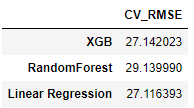
По результатам лучшей метрикой `RMSE` обладает модель **линейной регрессии**

## Тестирование

Для начала введем `Dummy Regressor` со стратегией по умолчанию(заполнение средним)

In [71]:
#тестирование
#dummy model
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
dummy_score = mean_squared_error(dummy_pred, y_test, squared = False)
print(f'Dummy RMSE : {dummy_score:.3f}')

Dummy RMSE : 84.819


In [72]:
%%time
#lr test v2
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)
lr_score = mean_squared_error(lr_pred, y_test, squared = False)
print(f"RMSE Linear Regression на тестовой выборке: {lr_score:.3f}")

RMSE Linear Regression на тестовой выборке: 45.500
CPU times: user 46.7 ms, sys: 112 ms, total: 159 ms
Wall time: 75.5 ms


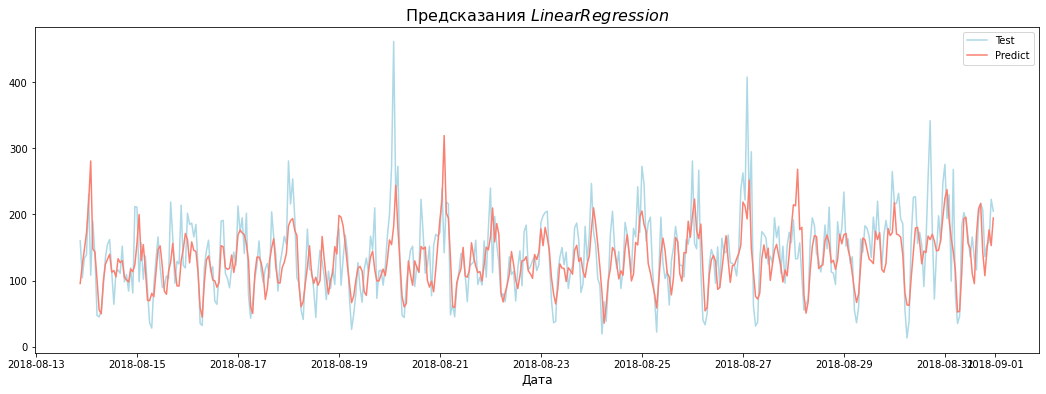

In [73]:
#график
plt.figure(figsize = (18,6))
plt.plot(y_test.index, 
         y_test, 
         'lightblue', 
         y_test.index, 
         lr_pred,
         'salmon'
        )
plt.legend(['Test', 'Predict'])
plt.title('Предсказания $LinearRegression$', fontsize = 16)
plt.xlabel('Дата', fontsize = 12);

## Вывод

Были проанализрованы данные о заказах такси за временной период с марта по август 2018 г.
Произведено ресэмплирование данных в часовом интервале с суммированием заказов. 
Проанализировано количество заказов, проверена монотонность временного ряда, подобрано количество лагов на основании анализа сезонности заказов ряда - 24 лага и размер окна скользящего среднего в 72 часа

Подобранны гиперпараметры для моделей градиентного бустинга и случайного леса, на этапе кросс-валидации отобрана модель линейной регресии. 
После проверки на тестовой выборке был получен положительный результат: 
- Linear Regression: RMSE = 45.5
<br>

Для сравнения, `Dummy` модель со стратегией `strategy = mean` дает результат 84.81